# Radiative Transfer (```rad_transfer```)

In [46]:
import empylib.rad_transfer as rt
import empylib.nklib as nk
import numpy as np
import matplotlib.pyplot as plt

For radiative transfer we rely on two libraries:
- ```rad_transfer``` with functions for simple calculations (e.g., Beer–Lambert)
- ```iadpython``` for multiple‑scattering simulations

## Beer–Lambert (```T_beer_lambert```)
The function ```T_beer_lambert``` in ```empylib.rad_transfer``` uses Beer-Lambert law to compute total/specular transmittance and total reflectance through a slab of thickness $d$ containing inclusions.


In [47]:
help(rt.T_beer_lambert)

Help on function T_beer_lambert in module empylib.rad_transfer:

T_beer_lambert()
       Transmittance and reflectance from Beer-Lamberts law for a film with 
       spherical particles. Reflectance is computed from classical formulas for
       incoherent light incident on a slab between two semi-infinite media 
       (no scattering is considered for this parameter)
    
    Parameters
       ----------
       lam : array-like, shape (nλ,)
           Wavelengths [µm], strictly positive.
    
       Nh : float or array-like (nλ,)
           Host refractive index (can be complex). If array-like, length must equal len(lam).
    
       Np (float, 1darray or list): Complex refractive index of each 
                                               shell layer. Np.shape[1] == len(D). 
           Options are:
           float:   solid sphere and constant refractive index
           1darray: solid sphere and spectral refractive index (len = lam)
           list:    multilayered sphere (with bo

In the next example, we consider a **silica film** with pores; the upper and lower media are air. The light is incident at $\theta_i = 0^\circ$.

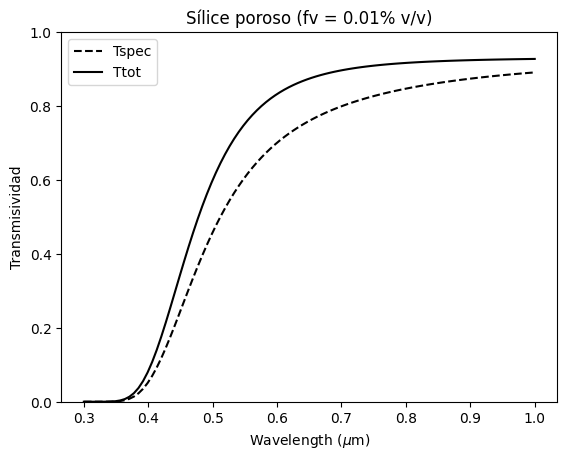

In [48]:
lam = np.linspace(0.3,1.0,100)  # wavelength grid (in microns)
theta = np.radians(0)           # 30 degrees in radians
tfilm = 1.0                     # thickness in mm
Nh = nk.SiO2(lam)               # refractive index: top, slab, bottom
fv = 0.0001                     # volume fraction of pores/inclusions
D = 0.2                         # pore/particle diameter (microns)
Np = 1.0                        # refractive index of inclusions

Ttot, Rtot, Tspec = rt.T_beer_lambert(lam, Nh, Np, D, fv, tfilm,
                                      theta = theta)

plt.plot(lam,Tspec,'--k',label = 'Tspec')
plt.plot(lam,Ttot,'-k',label = 'Ttot')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transmisividad')
plt.title(r'Sílice poroso (fv = 0.01% v/v)')
plt.legend()
plt.ylim(0,1)
plt.show()

## Multiple scattering of spherical particles (```adm_sphere```)

The function ```adm_sphere``` in ```empylib.rad_transfer``` implements the **adding–doubling method (ADM)** to solve the radiative transfer equation (RTE) numerically.


In [49]:
help(rt.adm_sphere)

Help on function adm_sphere in module empylib.rad_transfer:

adm_sphere()
    Parameters
    ----------
    lam : array-like, shape (nλ,)
        Wavelengths [µm], strictly positive.
    
    Nh : float or array-like (nλ,)
        Host refractive index (can be complex). If array-like, length must equal len(lam).
    
    Np (float, 1darray or list): Complex refractive index of each 
                                            shell layer. Np.shape[1] == len(D). 
        Options are:
        float:   solid sphere and constant refractive index
        1darray: solid sphere and spectral refractive index (len = lam)
        list:    multilayered sphere (with both constant or spectral refractive indexes)
    
    D : float, _np.ndarray or list
        Diameter of the spheres. Use float for monodisperse, or array for polydisperse.
        if multilayer sphere, use list of floats (monodisperse) or arrays (polydisperse).
    
    fv : float
        Particle volume fraction in (0, 1). Used only

### Monodispersed particles

In the example, we model an **acrilic film (PMMA)** with TiO$_2$ particles using ADM over $\lambda\in[0.3,1.0]$ $\mu$m.

Extrapolating (C5H8O2)n - poly(methyl methacrylate)_Zhang-Tomson refractive index below tabulated range (requested min 0.200 µm; data starts 0.400 µm)


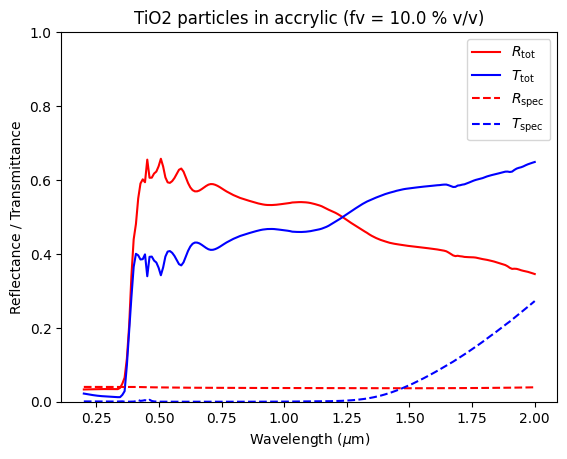

In [50]:
lam = np.linspace(0.2, 2.0, 200) # espectro de longitudes de onda
tfilm = 0.010                    # thickness in mm
Nh = nk.PMMA(lam)                # índice de refracción del medio (agua)
fv = 0.10                        # volume fraction of pores/inclusions
Dp = 0.500                       # particle diameter (microns)
Np = nk.TiO2(lam)                # índice de refracción partícula

Ttot, Rtot, Tspec, Rspec = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm)

plt.plot(lam,Rtot,'-r',label='$R_\mathrm{tot}$')
plt.plot(lam,Ttot,'-b',label='$T_\mathrm{tot}$')
plt.plot(lam,Rspec,'--r',label='$R_\mathrm{spec}$')
plt.plot(lam,Tspec,'--b',label='$T_\mathrm{spec}$')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(r'TiO2 particles in accrylic (fv = %.1f %% v/v)' % (fv*100))
plt.legend()
plt.ylim(0,1)
plt.show()

#### Effect of dependent scattering and effective medium theory

By default, `adm_sphere` consider scattering independent particles, and no effective medium theory is applied. However, we can change those options by setting
the arguments `dependent_scatt` and `effective_medium`.

Let's analyze the same problem, now with effective medium and dependent scattering. We will only analyze Total Reflectance and transmittance in this case to keep the plot cleaner.

In [51]:
Ttot_eff, Rtot_eff, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     effective_medium=True)

Ttot_ds_eff, Rtot_dsds_eff, *_ = rt.adm_sphere(lam, Nh, Np, D, fv, tfilm,
                                     dependent_scatt=True,
                                     effective_medium=True)

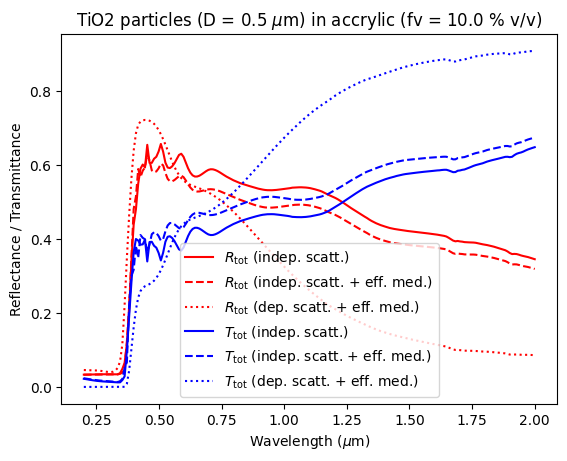

In [52]:
# plotting reflectance
plt.plot(lam,Rtot,'-r',label='$R_\mathrm{tot}$ (indep. scatt.)')
plt.plot(lam,Rtot_eff,'--r',label='$R_\mathrm{tot}$ (indep. scatt. + eff. med.)')
plt.plot(lam,Rtot_dsds_eff,':r',label='$R_\mathrm{tot}$ (dep. scatt. + eff. med.)')

# plotting transmittance
plt.plot(lam,Ttot,'-b',label='$T_\mathrm{tot}$ (indep. scatt.)')
plt.plot(lam,Ttot_eff,'--b',label='$T_\mathrm{tot}$ (indep. scatt. + eff. med.)')
plt.plot(lam,Ttot_ds_eff,':b',label='$T_\mathrm{tot}$ (dep. scatt. + eff. med.)')

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(f'TiO2 particles (D = {Dp:.1f} $\mu$m) in accrylic (fv = {fv*100:.1f} % v/v)')
plt.legend()
# plt.ylim(0,1)
plt.show()

#### Phase function vs Asymmetry parameter

`adm_sphere` uses the asymmetry parameter by defaul in all its internal calculations. We can use the phase function of the scattering media, instead, with the argument `use_phase_fun ` to get more precise results.

Let's compare the results between asymmetry parameter and phase function for the independent and dependent scattering cases. We will set effective media in both.

In [ ]:
# case 1: independent scattering with effective medium
Ttot_c1_gcos, Rtot_c1_gcos, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     effective_medium=True)

Ttot_c1_psca, Rtot_c1_psca, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     use_phase_fun=True,
                                     effective_medium=True)

# case 2: dependent scattering with effective medium
Ttot_c2_gcos, Rtot_c2_gcos, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     dependent_scatt=True,
                                     effective_medium=True)

Ttot_c2_psca, Rtot_c2_psca, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     use_phase_fun=True,
                                     dependent_scatt=True,
                                     effective_medium=True)

(0.0, 1.0)

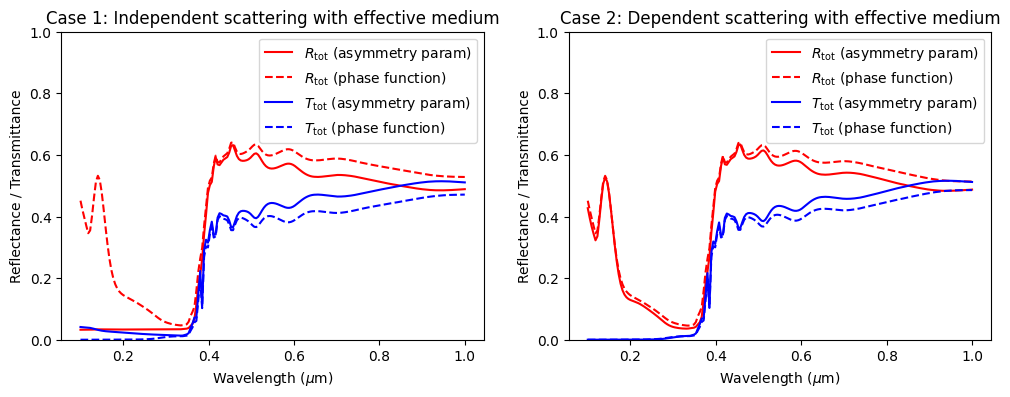

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(lam,Rtot_c1_gcos,'-r',label='$R_\mathrm{tot}$ (asymmetry param)')
ax[0].plot(lam,Rtot_c1_psca,'--r',label='$R_\mathrm{tot}$ (phase function)')
ax[0].plot(lam,Ttot_c1_gcos,'-b',label='$T_\mathrm{tot}$ (asymmetry param)')    
ax[0].plot(lam,Ttot_c1_psca,'--b',label='$T_\mathrm{tot}$ (phase function)')
ax[0].set_title('Case 1: Independent scattering with effective medium')
ax[0].set_xlabel('Wavelength ($\mu$m)')
ax[0].set_ylabel('Reflectance / Transmittance')
ax[0].legend()
ax[0].set_ylim(0,1)

ax[1].plot(lam,Rtot_c2_gcos,'-r',label='$R_\mathrm{tot}$ (asymmetry param)')
ax[1].plot(lam,Rtot_c2_psca,'--r',label='$R_\mathrm{tot}$ (phase function)')
ax[1].plot(lam,Ttot_c2_gcos,'-b',label='$T_\mathrm{tot}$ (asymmetry param)')    
ax[1].plot(lam,Ttot_c2_psca,'--b',label='$T_\mathrm{tot}$ (phase function)')
ax[1].set_title('Case 2: Dependent scattering with effective medium')
ax[1].set_xlabel('Wavelength ($\mu$m)')
ax[1].set_ylabel('Reflectance / Transmittance')
ax[1].legend()
ax[1].set_ylim(0,1)

plt.show()
